In [0]:
!mkdir results

In [3]:
"""
 This code is sourced from the repo https://github.com/pytorch/examples
 All credit goes to the original author
"""
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional
from torchvision import datasets, transforms
from torchvision.utils import save_image
from enum import Enum

class Dataset(Enum):
    mnsit = 1
    fashion_mnist = 2


# configuration parameters
epochs=10
batch_size=128
data_dir='../data' #dir to download dataset
output_dir='results/' # output dir
data_set=Dataset.fashion_mnist

class VAE:
    def __init__(self,train_data,test_data):
        self.model=Model()
        self.train_data=train_data
        self.test_data=test_data
        # initialize optimizer
        # adam optimizer is used instead of adagrad for better convergence
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

    # loss function defined as sum of KL divergence and reconstruction loss
    def loss_function(self,recon_x, x, mu, logvar):
        recon_loss = functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kld

    def train(self,epoch):
        self.model.train()
        train_loss = 0
        for batch_index, (data, _) in enumerate(train_data):
            self.optimizer.zero_grad()
            recon_batch, mu, logvar = self.model(data)
            loss = self.loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()
            if batch_index % 100 == 0:
                print('Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item() / len(data)))
        print('Average Train loss: {:.4f}'.format(train_loss / len(train_data.dataset)))

    def test(self):
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(test_data):
                recon_batch, mu, logvar = self.model(data)
                test_loss += self.loss_function(recon_batch, data, mu, logvar).item()
        test_loss /= len(test_data.dataset)
        print('Test loss: {:.4f}'.format(test_loss))


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # ReLU are used instead of sigmoid function for faster computation
    def encode(self, x):
        h1 = functional.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = functional.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# download the Fashion-MNIST data using torchvision dataset
if data_set==Dataset.fashion_mnist:
    train_data = torch.utils.data.DataLoader(datasets.FashionMNIST(data_dir, train=True, download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
    test_data = torch.utils.data.DataLoader(datasets.FashionMNIST(data_dir, train=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
else:
    train_data = torch.utils.data.DataLoader(datasets.MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
    test_data = torch.utils.data.DataLoader(datasets.MNIST(data_dir, train=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)

vae=VAE(train_data,test_data)
# start training the model
for epoch in range(1, epochs + 1):
    vae.train(epoch)
    vae.test()
    with torch.no_grad():
        # generate samples
        sample = torch.randn(64, 20)
        sample = vae.model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28), output_dir + 'vae_' +str(epoch) + '.png')

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!
Epoch: 1 	Loss: 549.621033
Epoch: 1 	Loss: 282.092560
Epoch: 1 	Loss: 276.921814
Epoch: 1 	Loss: 289.468506
Epoch: 1 	Loss: 263.954498
Average Train loss: 285.4297
Test loss: 263.0685
Epoch: 2 	Loss: 254.426682
Epoch: 2 	Loss: 242.912781
Epoch: 2 	Loss: 254.633575
Epoch: 2 	Loss: 264.970276
Epoch: 2 	Loss: 248.881363
Average Train loss: 256.3837
Test loss: 254.1140
Epoch: 3 	Loss: 251.582214
Epoch: 3 	Loss: 258.170898
Epoch: 3 	Loss: 254.392319
Epoch: 3 	Loss: 247.157150
Epoch: 3 	Loss: 244.558029
Average Train loss: 250.4342
Test loss: 250.2268
Epoch: 4 	Loss: 248.404236
Epoch: 4 	Loss: 241.374802
Epoch: 4 	Loss: 245.865021
Epoch: 4 	Loss: 235.787399
Epoch: 4 	Loss: 242.992172
Average Train loss: 247.4676
Test loss: 248.0887
Epoch: 5 	Loss: 246.205200
Epoch: 5 	Loss: 243.857452
Epoch: 5 	Loss: 234.828339
Epoch: 5 	Loss: 256.417633
Epoch: 5 	Loss: 245.697357
Average Train loss:

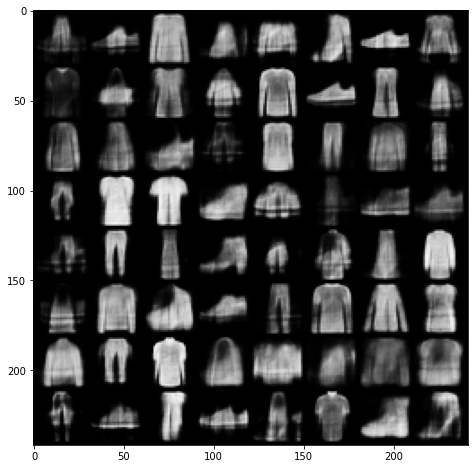

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(8, 8))
img=mpimg.imread('results/vae_10.png')
imgplot = plt.imshow(img)
plt.show()